**BUSINESS PROBLEM and DATASET**

In this project, a machine learning model has been developed to predict house prices. In the dataset, there are various features of each house and the prices of the houses.

**DATASET STORY**

This dataset of residential houses in Lowa, Ames contains 79 explanatory variables.
Since the dataset belongs to a kaggle competition, there are two different csv files, train and test.
House prices are left blank in the test data set, and you are expected to estimate these values.

***Importing the Essential Libraries, Metrics***

In [52]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 80)

***Loading the Data***

In [53]:
train = pd.read_csv("PycharmProjects/pythonProject/DATASETS/train.csv")
test = pd.read_csv("PycharmProjects/pythonProject/DATASETS/test.csv")
df = pd.concat([train, test], ignore_index=True)
df_Id = df["Id"]
df.drop("Id", axis=1, inplace=True)


# 1-EDA (Exploratory Data Analysis) #

**-SUMMARY-**

In [54]:
def summarize(dataframe):
    print(f"Dataset Shape: {dataframe.shape}")
    summary = pd.DataFrame(dataframe.dtypes, columns=["dtypes"])
    summary = summary.reset_index()
    summary["Name"] = summary["index"]
    summary = summary[["Name", "dtypes"]]
    summary["Missing"] = dataframe.isnull().sum().values
    summary["Uniques"] = dataframe.nunique().values
    summary["First Value"] = dataframe.loc[0].values
    summary["Second Value"] = dataframe.loc[1].values
    summary["Third Value"] = dataframe.loc[2].values
    summary["Fourth Value"] = dataframe.loc[3].values
    summary["Fifth Value"] = dataframe.loc[4].values

    return summary

summarize(df)

Dataset Shape: (2919, 80)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Fourth Value,Fifth Value
0,MSSubClass,int64,0,16,60,20,60,70,60
1,MSZoning,object,4,5,RL,RL,RL,RL,RL
2,LotFrontage,float64,486,128,65.0,80.0,68.0,60.0,84.0
3,LotArea,int64,0,1951,8450,9600,11250,9550,14260
4,Street,object,0,2,Pave,Pave,Pave,Pave,Pave
5,Alley,object,2721,2,NaN,NaN,NaN,NaN,NaN
6,LotShape,object,0,4,Reg,Reg,IR1,IR1,IR1
7,LandContour,object,0,4,Lvl,Lvl,Lvl,Lvl,Lvl
8,Utilities,object,2,2,AllPub,AllPub,AllPub,AllPub,AllPub
9,LotConfig,object,0,5,Inside,FR2,Inside,Corner,FR2


**Converting from Numeric to Categorical**

In [55]:
df[["MSSubClass", "OverallQual", "MoSold"]] = df[["MSSubClass", "OverallQual", "MoSold"]].astype("O")

**Capturing Numeric and Categorical variables**

In [56]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [57]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 2919
Variables: 80
cat_cols: 55
num_cols: 24
cat_but_car: 1
num_but_cat: 10


In [58]:
cat_cols

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'SaleType',
 'SaleCondition',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'YrSold']

In [59]:
num_cols

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'SalePrice']

In [12]:
cat_but_car

['Neighborhood']

**Numerical Variables Analysis**

In [60]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
5%         32.000000
10%        43.000000
25%        59.000000
50%        68.000000
75%        80.000000
99%       135.680000
max       313.000000
Name: LotFrontage, dtype: float64


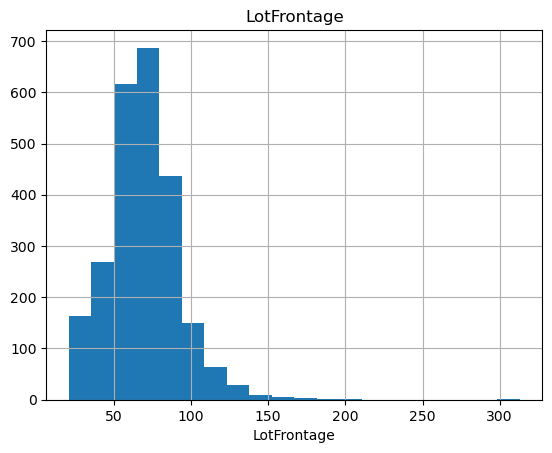

#############################################################################
count      2919.000000
mean      10168.114080
std        7886.996359
min        1300.000000
5%         3182.000000
10%        4922.400000
25%        7478.000000
50%        9453.000000
75%       11570.000000
99%       33038.640000
max      215245.000000
Name: LotArea, dtype: float64


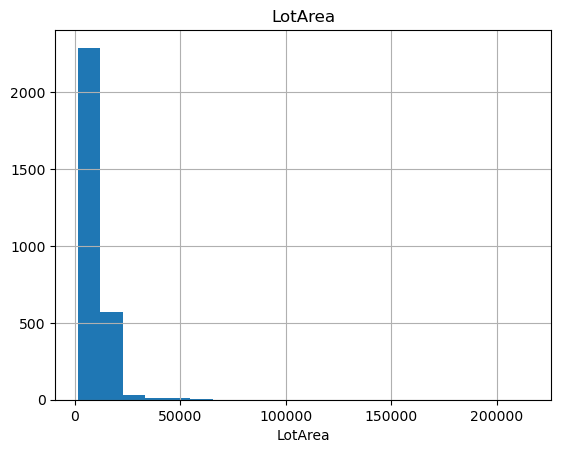

#############################################################################
count    2919.000000
mean     1971.312778
std        30.291442
min      1872.000000
5%       1915.000000
10%      1924.000000
25%      1953.500000
50%      1973.000000
75%      2001.000000
99%      2008.000000
max      2010.000000
Name: YearBuilt, dtype: float64


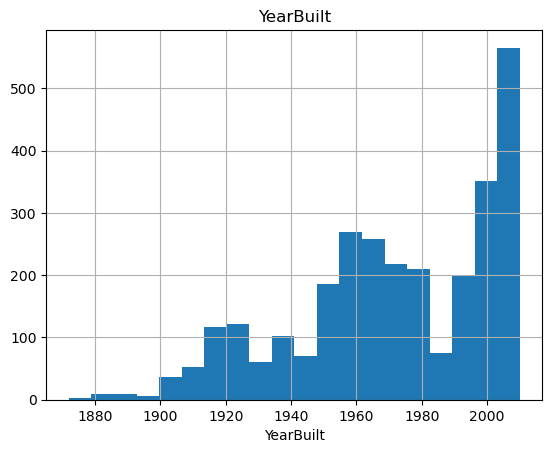

#############################################################################
count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
5%       1950.000000
10%      1950.000000
25%      1965.000000
50%      1993.000000
75%      2004.000000
99%      2009.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


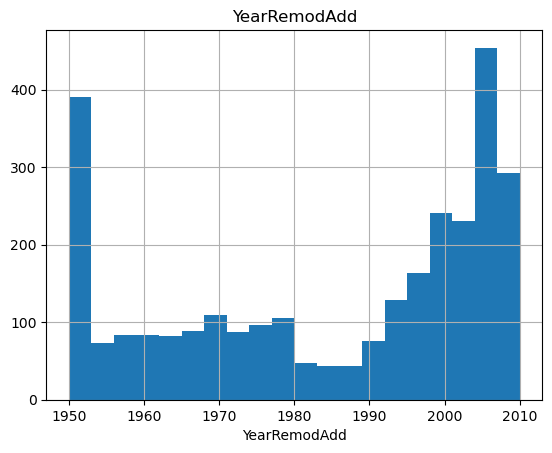

#############################################################################
count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
99%       771.050000
max      1600.000000
Name: MasVnrArea, dtype: float64


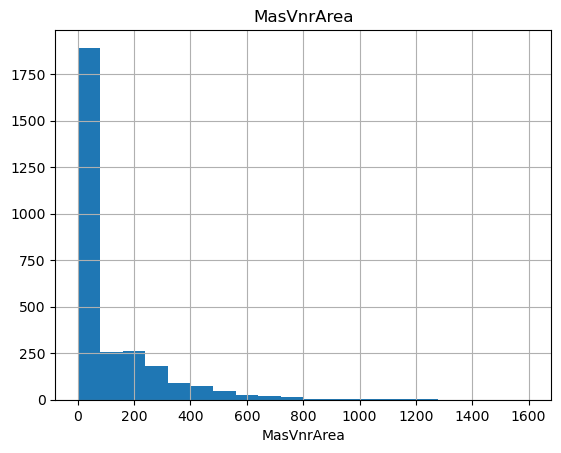

#############################################################################
count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%       368.500000
75%       733.000000
99%      1635.320000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


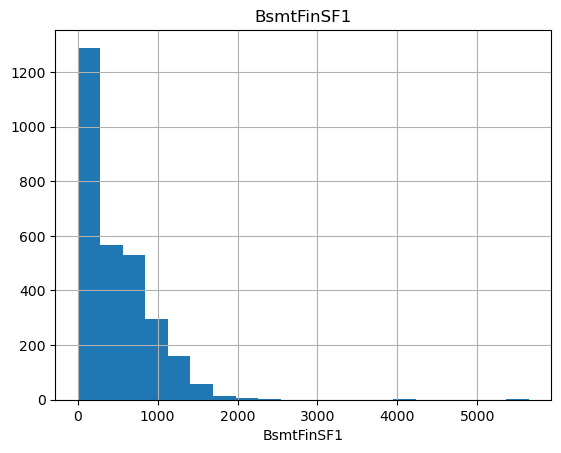

#############################################################################
count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
99%       874.660000
max      1526.000000
Name: BsmtFinSF2, dtype: float64


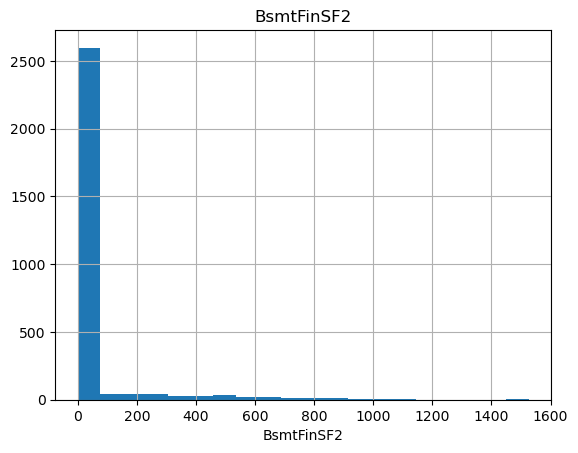

#############################################################################
count    2918.000000
mean      560.772104
std       439.543659
min         0.000000
5%          0.000000
10%        56.000000
25%       220.000000
50%       467.000000
75%       805.500000
99%      1776.490000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


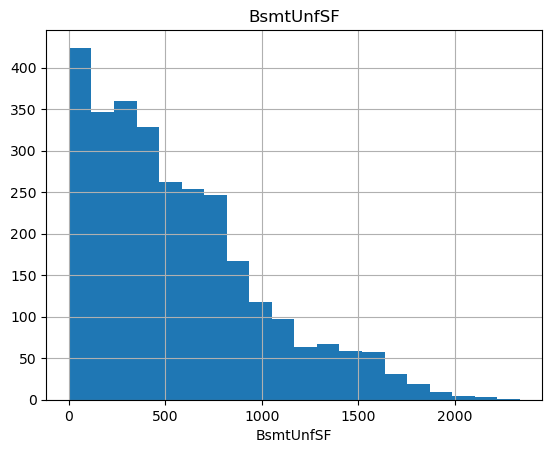

#############################################################################
count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
5%        455.250000
10%       600.000000
25%       793.000000
50%       989.500000
75%      1302.000000
99%      2198.300000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


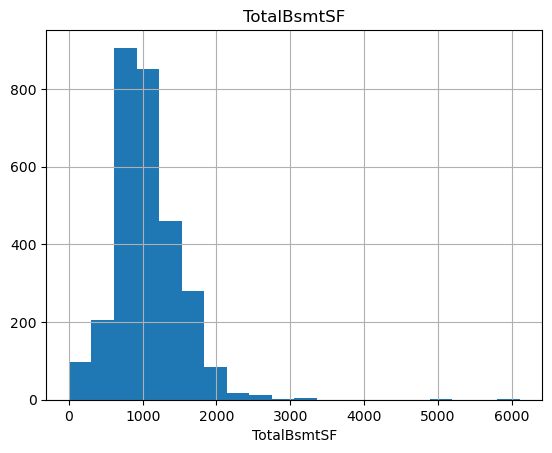

#############################################################################
count    2919.000000
mean     1159.581706
std       392.362079
min       334.000000
5%        665.900000
10%       744.800000
25%       876.000000
50%      1082.000000
75%      1387.500000
99%      2288.020000
max      5095.000000
Name: 1stFlrSF, dtype: float64


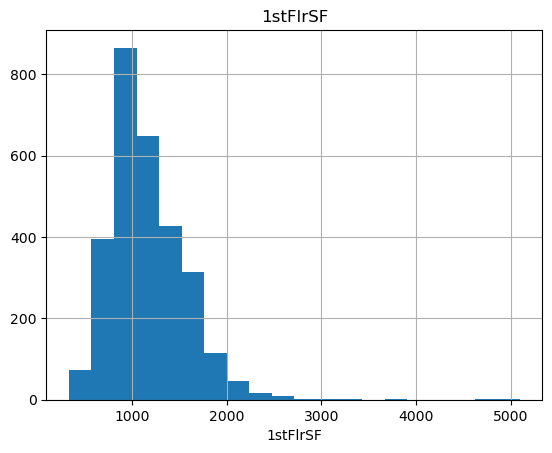

#############################################################################
count    2919.000000
mean      336.483727
std       428.701456
min         0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%       704.000000
99%      1400.200000
max      2065.000000
Name: 2ndFlrSF, dtype: float64


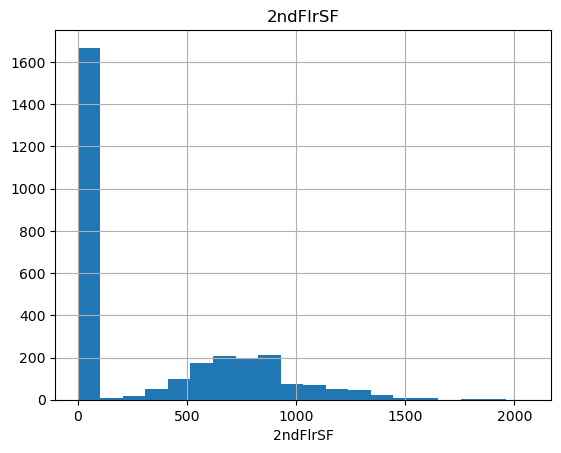

#############################################################################
count    2919.000000
mean        4.694416
std        46.396825
min         0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
99%       153.840000
max      1064.000000
Name: LowQualFinSF, dtype: float64


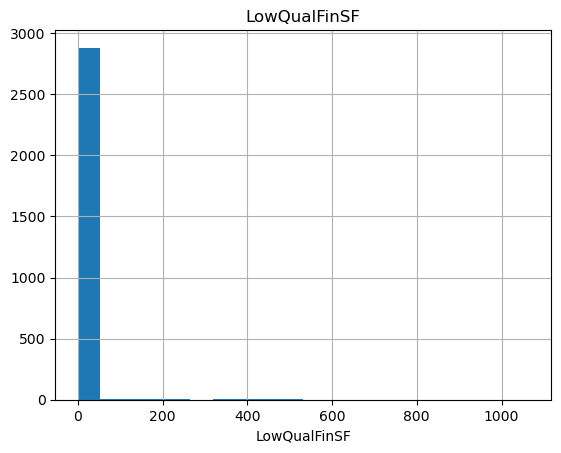

#############################################################################
count    2919.000000
mean     1500.759849
std       506.051045
min       334.000000
5%        861.000000
10%       923.800000
25%      1126.000000
50%      1444.000000
75%      1743.500000
99%      2935.720000
max      5642.000000
Name: GrLivArea, dtype: float64


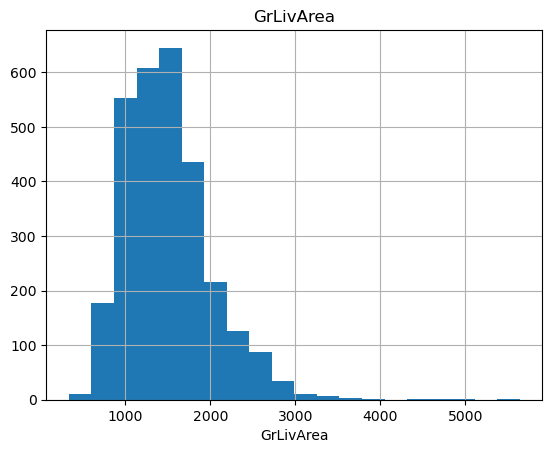

#############################################################################
count    2919.000000
mean        6.451524
std         1.569379
min         2.000000
5%          4.000000
10%         5.000000
25%         5.000000
50%         6.000000
75%         7.000000
99%        11.000000
max        15.000000
Name: TotRmsAbvGrd, dtype: float64


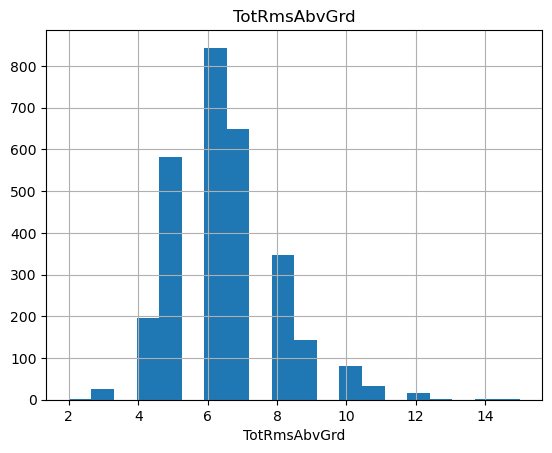

#############################################################################
count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
5%       1928.000000
10%      1941.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
99%      2009.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64


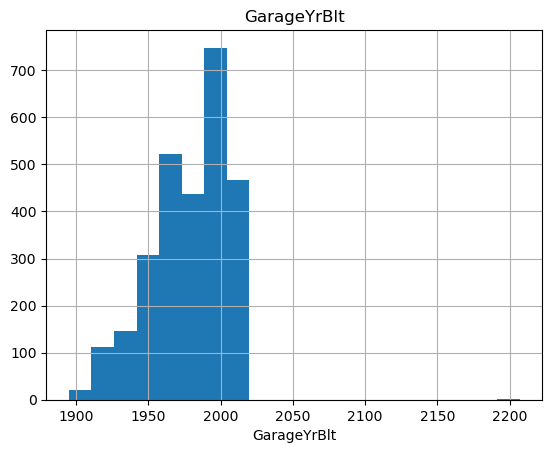

#############################################################################
count    2918.000000
mean      472.874572
std       215.394815
min         0.000000
5%          0.000000
10%       240.000000
25%       320.000000
50%       480.000000
75%       576.000000
99%      1019.490000
max      1488.000000
Name: GarageArea, dtype: float64


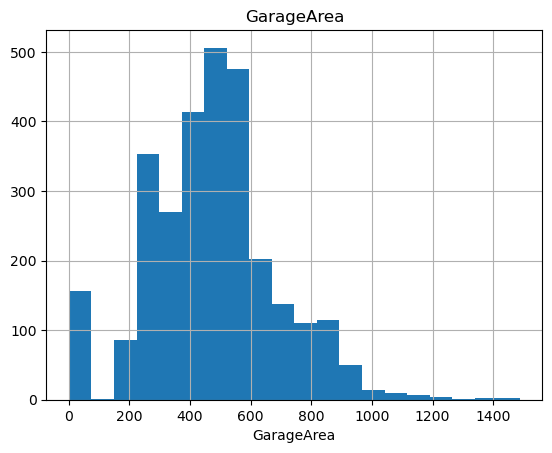

#############################################################################
count    2919.000000
mean       93.709832
std       126.526589
min         0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
99%       500.820000
max      1424.000000
Name: WoodDeckSF, dtype: float64


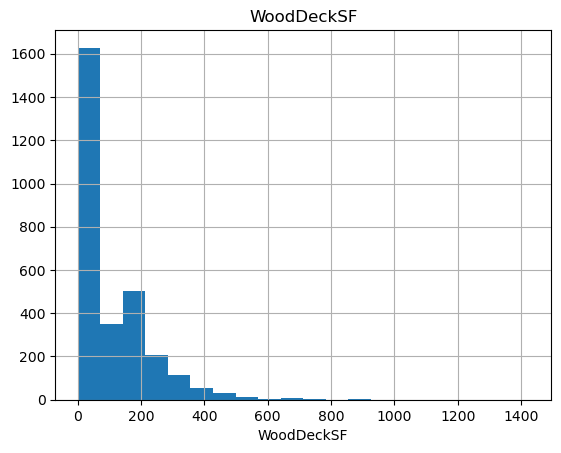

#############################################################################
count    2919.000000
mean       47.486811
std        67.575493
min         0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%        26.000000
75%        70.000000
99%       284.460000
max       742.000000
Name: OpenPorchSF, dtype: float64


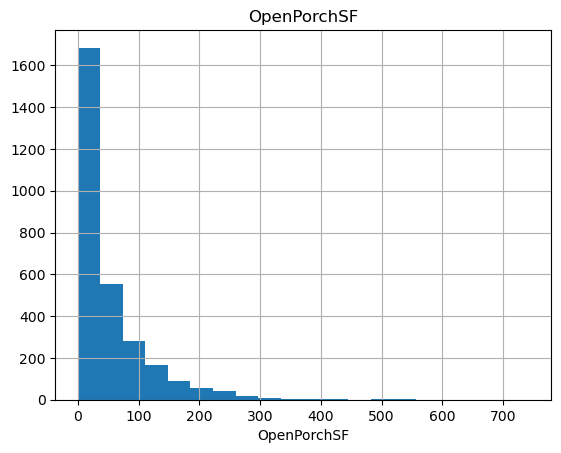

#############################################################################
count    2919.000000
mean       23.098321
std        64.244246
min         0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
99%       264.000000
max      1012.000000
Name: EnclosedPorch, dtype: float64


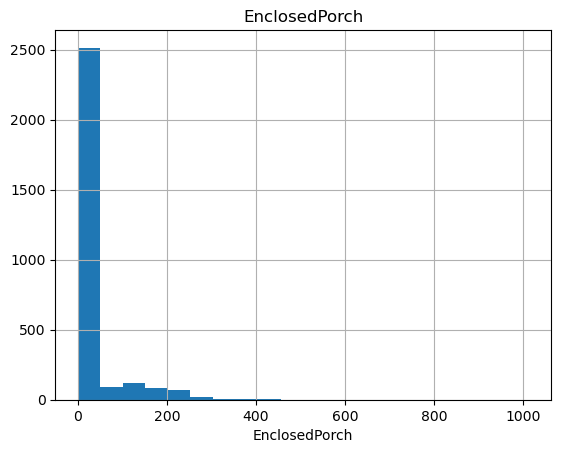

#############################################################################
count    2919.000000
mean        2.602261
std        25.188169
min         0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
99%       144.000000
max       508.000000
Name: 3SsnPorch, dtype: float64


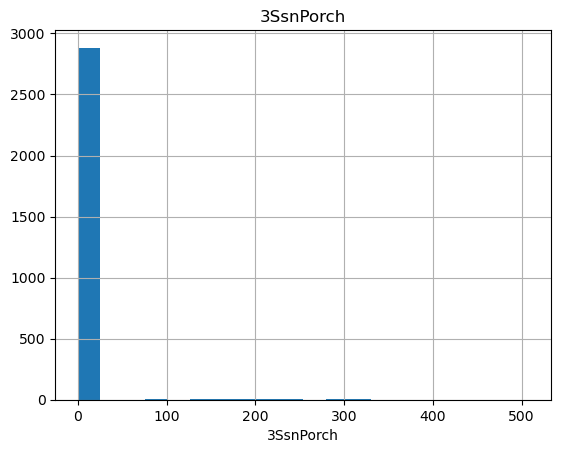

#############################################################################
count    2919.000000
mean       16.062350
std        56.184365
min         0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
99%       259.820000
max       576.000000
Name: ScreenPorch, dtype: float64


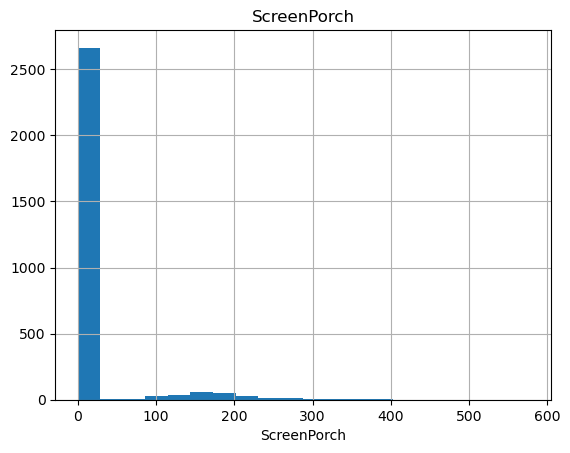

#############################################################################
count    2919.000000
mean        2.251799
std        35.663946
min         0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
99%         0.000000
max       800.000000
Name: PoolArea, dtype: float64


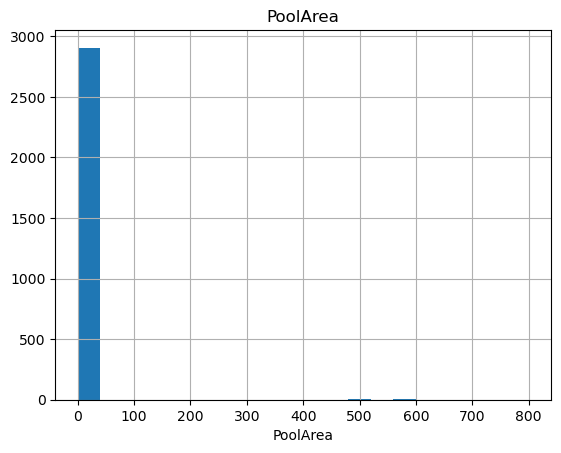

#############################################################################
count     2919.000000
mean        50.825968
std        567.402211
min          0.000000
5%           0.000000
10%          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
99%        982.000000
max      17000.000000
Name: MiscVal, dtype: float64


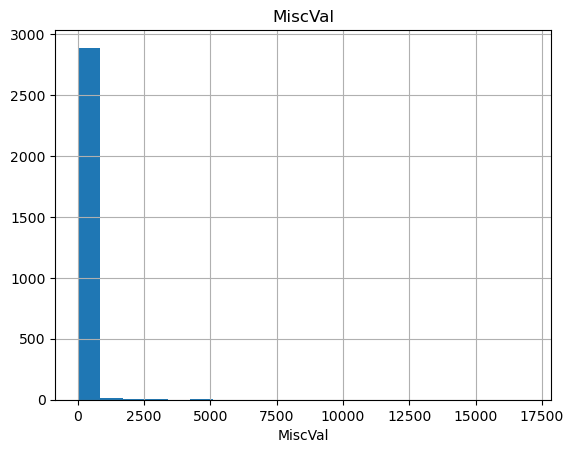

#############################################################################
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
5%        88000.000000
10%      106475.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
99%      442567.010000
max      755000.000000
Name: SalePrice, dtype: float64


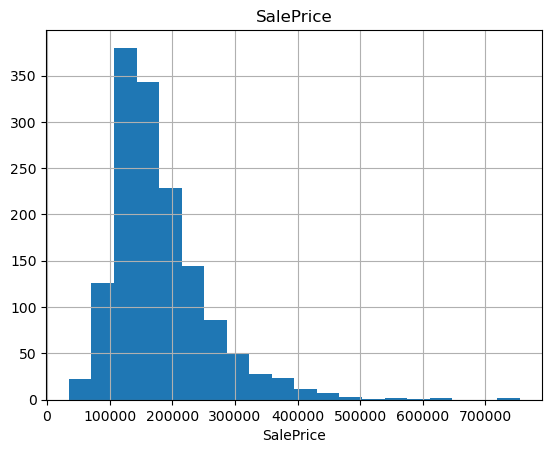

#############################################################################


In [61]:
for col in num_cols:
    num_summary(df, col, plot=True)
    print("#############################################################################")

**Categorical Variables Analysis**

In [62]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("#############################################################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

     MSSubClass      Ratio
20         1079  36.964714
60          575  19.698527
50          287   9.832134
120         182   6.235012
30          139   4.761905
70          128   4.385063
160         128   4.385063
80          118   4.042480
90          109   3.734156
190          61   2.089757
85           48   1.644399
75           23   0.787941
45           18   0.616650
180          17   0.582391
40            6   0.205550
150           1   0.034258
#############################################################################


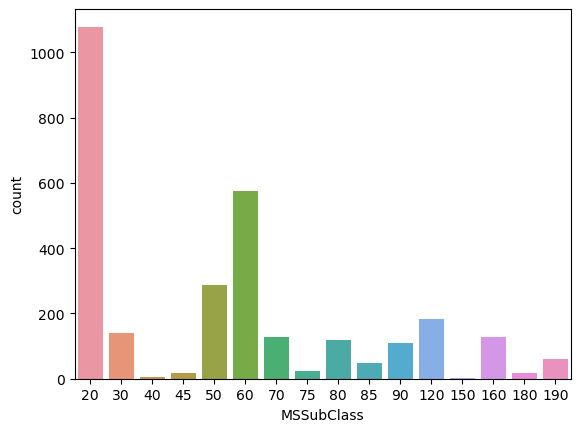

         MSZoning      Ratio
RL           2265  77.595067
RM            460  15.758822
FV            139   4.761905
RH             26   0.890716
C (all)        25   0.856458
#############################################################################


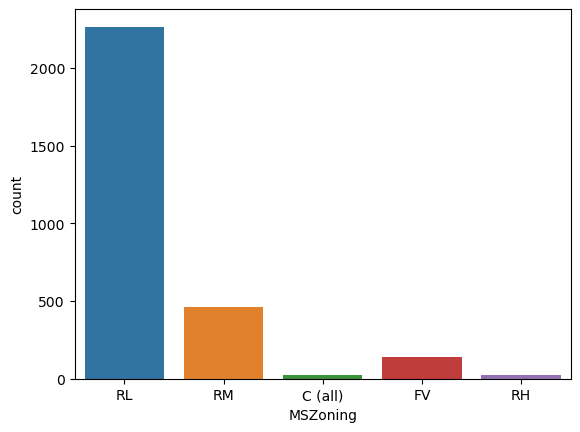

      Street    Ratio
Pave    2907  99.5889
Grvl      12   0.4111
#############################################################################


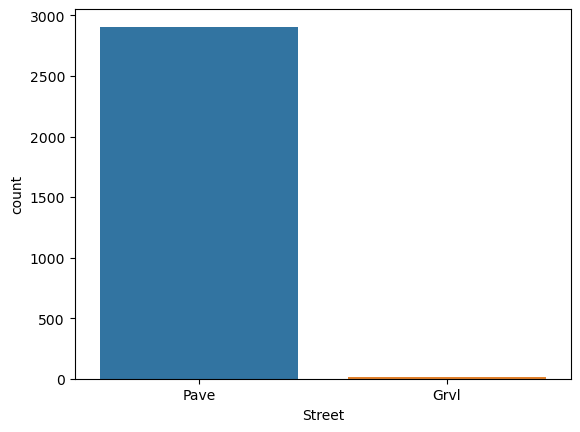

      Alley     Ratio
Grvl    120  4.110997
Pave     78  2.672148
#############################################################################


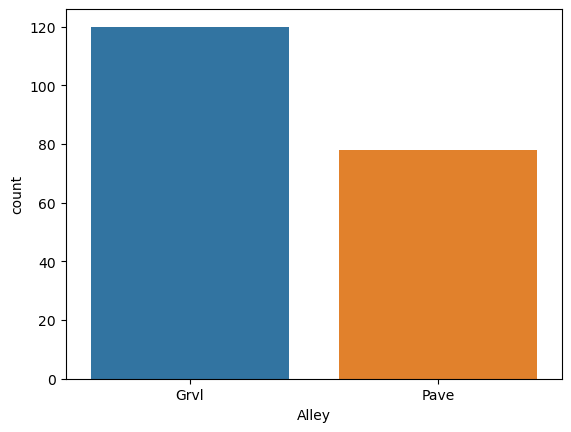

     LotShape      Ratio
Reg      1859  63.686194
IR1       968  33.162042
IR2        76   2.603631
IR3        16   0.548133
#############################################################################


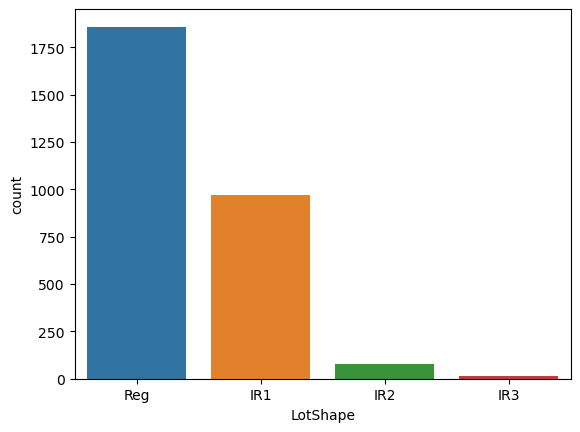

     LandContour      Ratio
Lvl         2622  89.825283
HLS          120   4.110997
Bnk          117   4.008222
Low           60   2.055498
#############################################################################


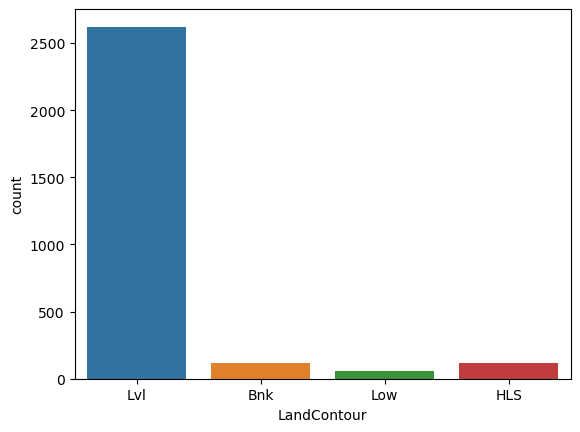

        Utilities      Ratio
AllPub       2916  99.897225
NoSeWa          1   0.034258
#############################################################################


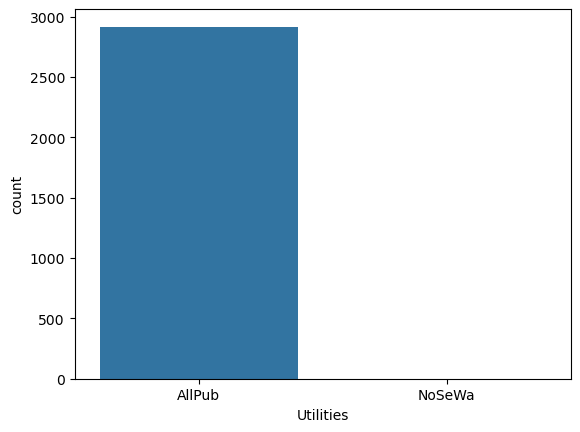

         LotConfig      Ratio
Inside        2133  73.072970
Corner         511  17.505995
CulDSac        176   6.029462
FR2             85   2.911956
FR3             14   0.479616
#############################################################################


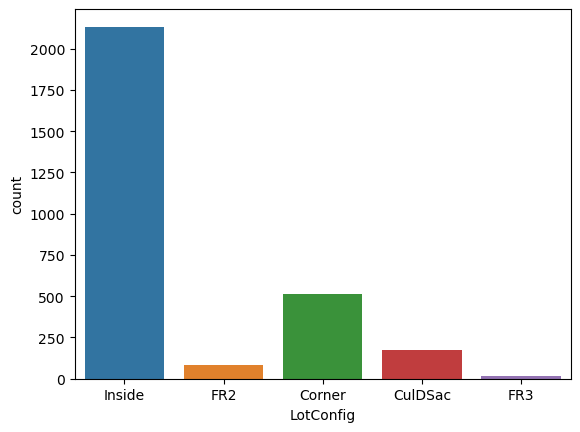

     LandSlope      Ratio
Gtl       2778  95.169579
Mod        125   4.282288
Sev         16   0.548133
#############################################################################


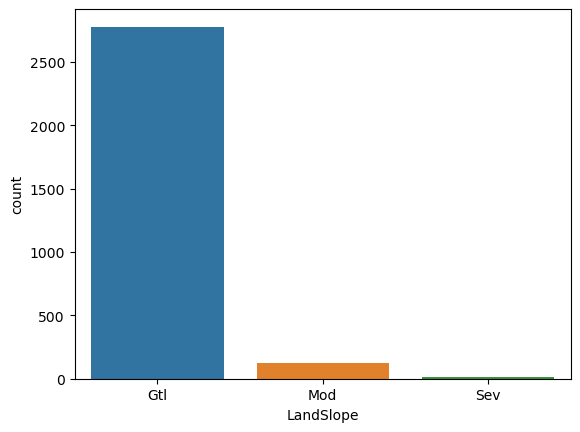

        Condition1      Ratio
Norm          2511  86.022610
Feedr          164   5.618362
Artery          92   3.151764
RRAn            50   1.712915
PosN            39   1.336074
RRAe            28   0.959233
PosA            20   0.685166
RRNn             9   0.308325
RRNe             6   0.205550
#############################################################################


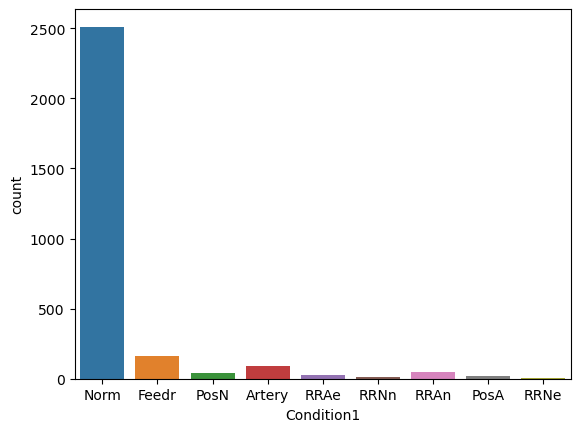

        Condition2      Ratio
Norm          2889  98.972251
Feedr           13   0.445358
Artery           5   0.171292
PosN             4   0.137033
PosA             4   0.137033
RRNn             2   0.068517
RRAn             1   0.034258
RRAe             1   0.034258
#############################################################################


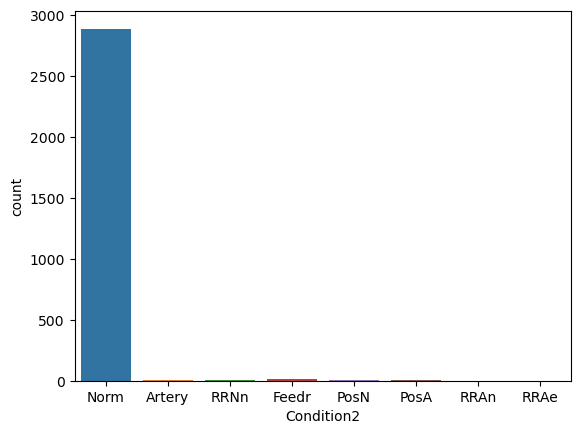

        BldgType      Ratio
1Fam        2425  83.076396
TwnhsE       227   7.776636
Duplex       109   3.734156
Twnhs         96   3.288798
2fmCon        62   2.124015
#############################################################################


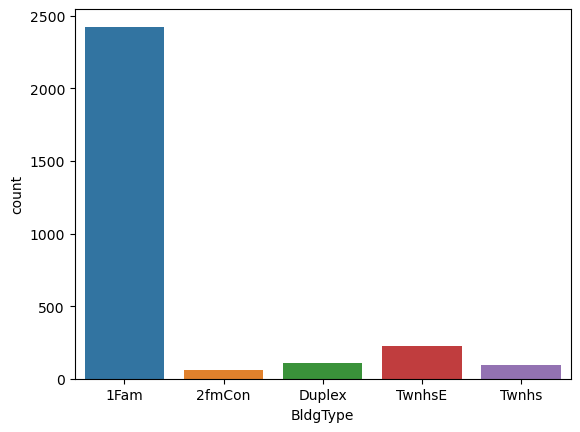

        HouseStyle      Ratio
1Story        1471  50.393971
2Story         872  29.873244
1.5Fin         314  10.757109
SLvl           128   4.385063
SFoyer          83   2.843440
2.5Unf          24   0.822199
1.5Unf          19   0.650908
2.5Fin           8   0.274066
#############################################################################


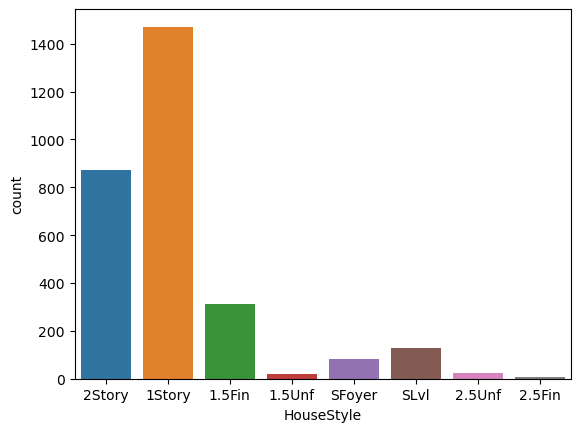

    OverallQual      Ratio
5           825  28.263104
6           731  25.042823
7           600  20.554985
8           342  11.716341
4           226   7.742378
9           107   3.665639
3            40   1.370332
10           31   1.062008
2            13   0.445358
1             4   0.137033
#############################################################################


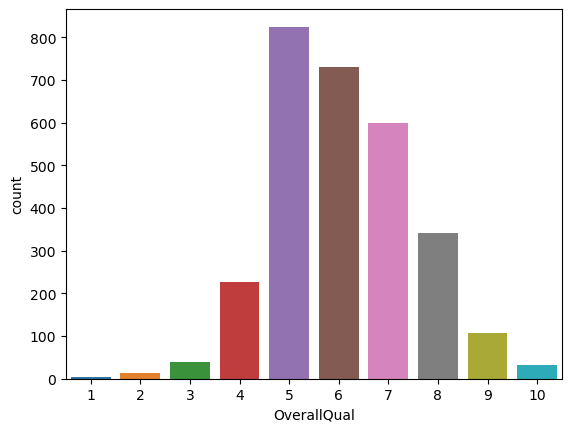

         RoofStyle      Ratio
Gable         2310  79.136691
Hip            551  18.876328
Gambrel         22   0.753683
Flat            20   0.685166
Mansard         11   0.376841
Shed             5   0.171292
#############################################################################


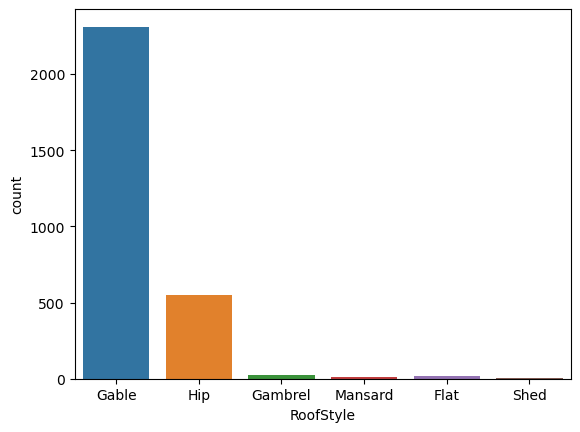

         RoofMatl      Ratio
CompShg      2876  98.526893
Tar&Grv        23   0.787941
WdShake         9   0.308325
WdShngl         7   0.239808
Metal           1   0.034258
Membran         1   0.034258
Roll            1   0.034258
ClyTile         1   0.034258
#############################################################################


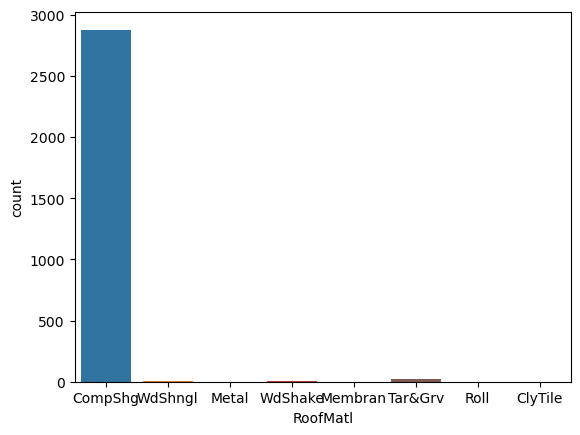

         Exterior1st      Ratio
VinylSd         1025  35.114765
MetalSd          450  15.416238
HdBoard          442  15.142172
Wd Sdng          411  14.080164
Plywood          221   7.571086
CemntBd          126   4.316547
BrkFace           87   2.980473
WdShing           56   1.918465
AsbShng           44   1.507366
Stucco            43   1.473107
BrkComm            6   0.205550
AsphShn            2   0.068517
Stone              2   0.068517
CBlock             2   0.068517
ImStucc            1   0.034258
#############################################################################


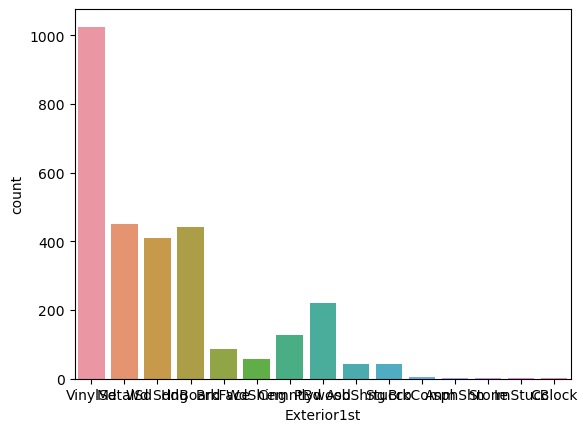

         Exterior2nd      Ratio
VinylSd         1014  34.737924
MetalSd          447  15.313464
HdBoard          406  13.908873
Wd Sdng          391  13.394998
Plywood          270   9.249743
CmentBd          126   4.316547
Wd Shng           81   2.774923
BrkFace           47   1.610140
Stucco            47   1.610140
AsbShng           38   1.301816
Brk Cmn           22   0.753683
ImStucc           15   0.513875
Stone              6   0.205550
AsphShn            4   0.137033
CBlock             3   0.102775
Other              1   0.034258
#############################################################################


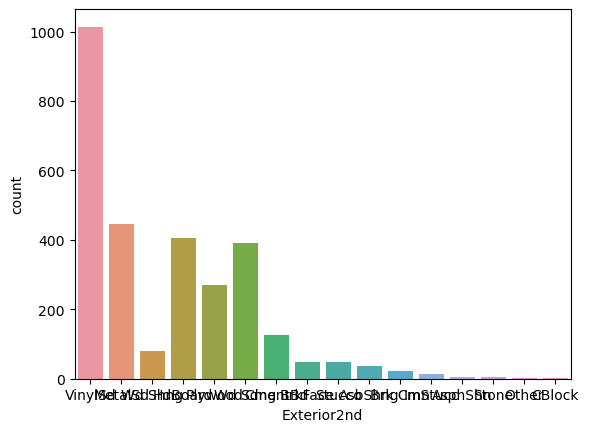

         MasVnrType      Ratio
None           1742  59.677972
BrkFace         879  30.113052
Stone           249   8.530319
BrkCmn           25   0.856458
#############################################################################


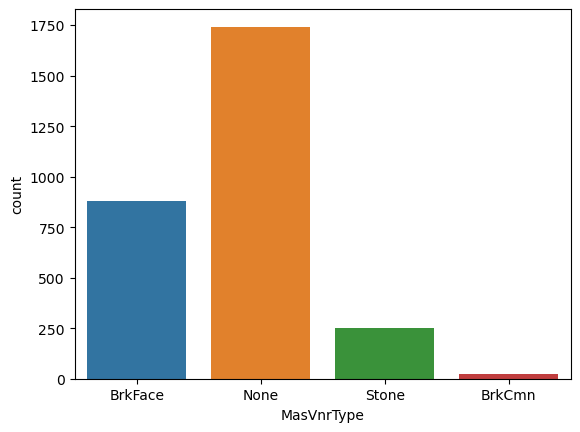

    ExterQual      Ratio
TA       1798  61.596437
Gd        979  33.538883
Ex        107   3.665639
Fa         35   1.199041
#############################################################################


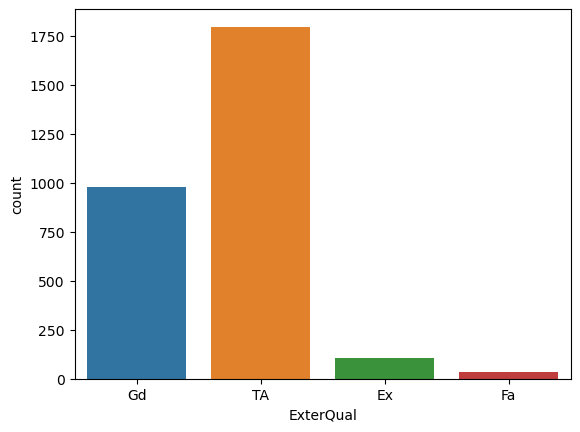

    ExterCond      Ratio
TA       2538  86.947585
Gd        299  10.243234
Fa         67   2.295307
Ex         12   0.411100
Po          3   0.102775
#############################################################################


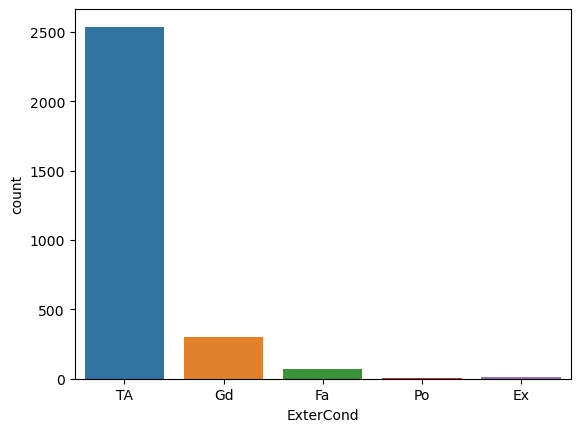

        Foundation      Ratio
PConc         1308  44.809866
CBlock        1235  42.309010
BrkTil         311  10.654334
Slab            49   1.678657
Stone           11   0.376841
Wood             5   0.171292
#############################################################################


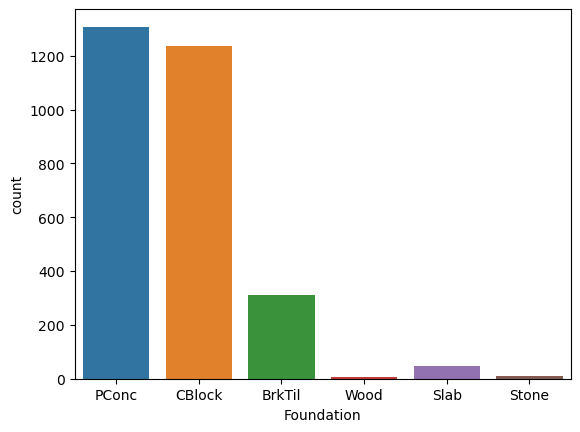

    BsmtQual      Ratio
TA      1283  43.953409
Gd      1209  41.418294
Ex       258   8.838643
Fa        88   3.014731
#############################################################################


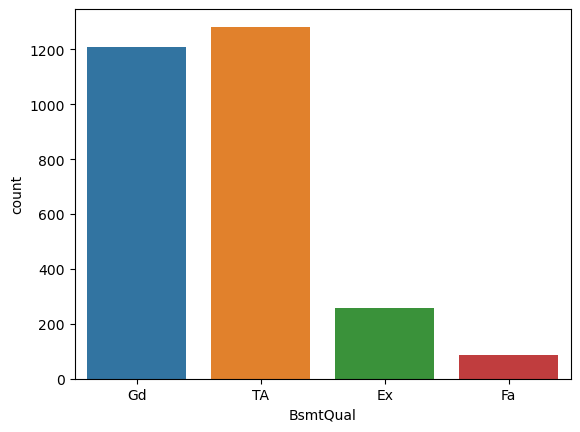

    BsmtCond      Ratio
TA      2606  89.277150
Gd       122   4.179514
Fa       104   3.562864
Po         5   0.171292
#############################################################################


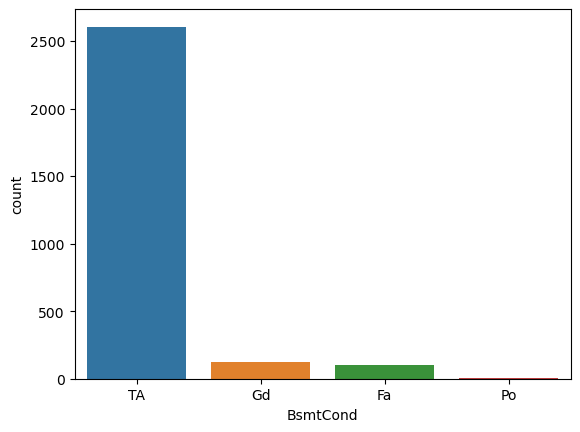

    BsmtExposure      Ratio
No          1904  65.227818
Av           418  14.319973
Gd           276   9.455293
Mn           239   8.187736
#############################################################################


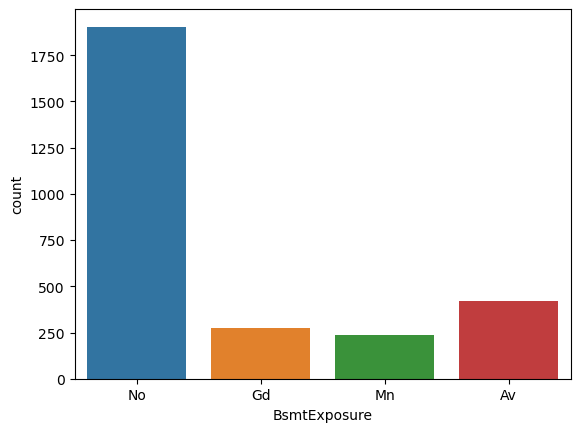

     BsmtFinType1      Ratio
Unf           851  29.153820
GLQ           849  29.085303
ALQ           429  14.696814
Rec           288   9.866393
BLQ           269   9.215485
LwQ           154   5.275779
#############################################################################


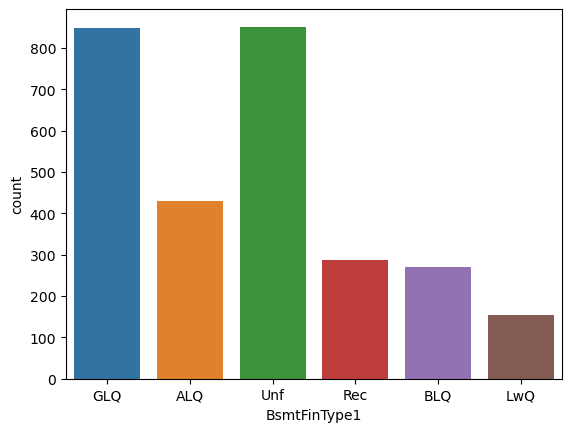

     BsmtFinType2      Ratio
Unf          2493  85.405961
Rec           105   3.597122
LwQ            87   2.980473
BLQ            68   2.329565
ALQ            52   1.781432
GLQ            34   1.164782
#############################################################################


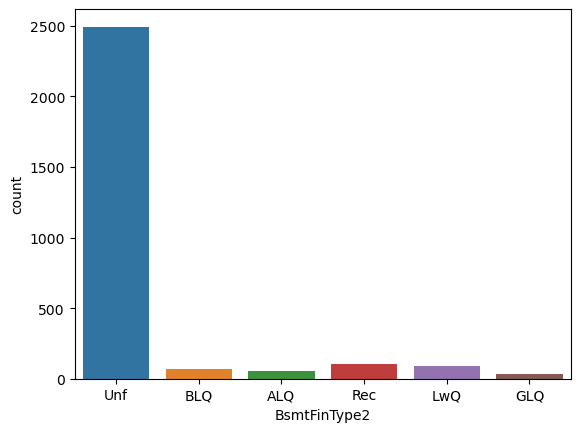

       Heating      Ratio
GasA      2874  98.458376
GasW        27   0.924974
Grav         9   0.308325
Wall         6   0.205550
OthW         2   0.068517
Floor        1   0.034258
#############################################################################


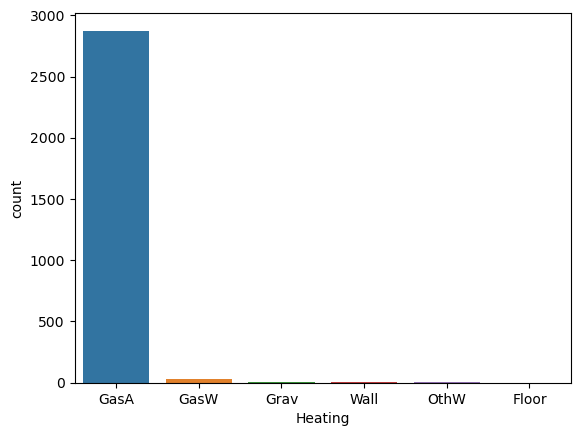

    HeatingQC      Ratio
Ex       1493  51.147653
TA        857  29.359370
Gd        474  16.238438
Fa         92   3.151764
Po          3   0.102775
#############################################################################


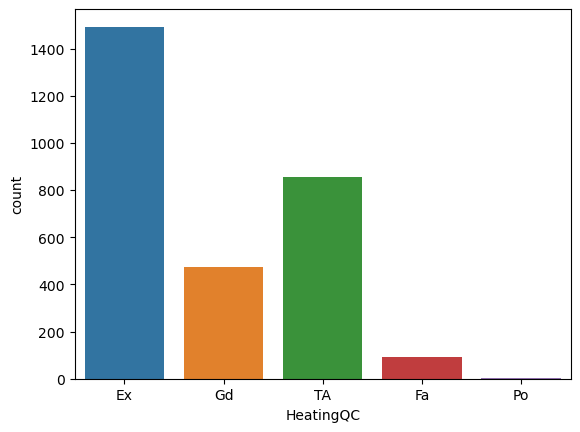

   CentralAir      Ratio
Y        2723  93.285372
N         196   6.714628
#############################################################################


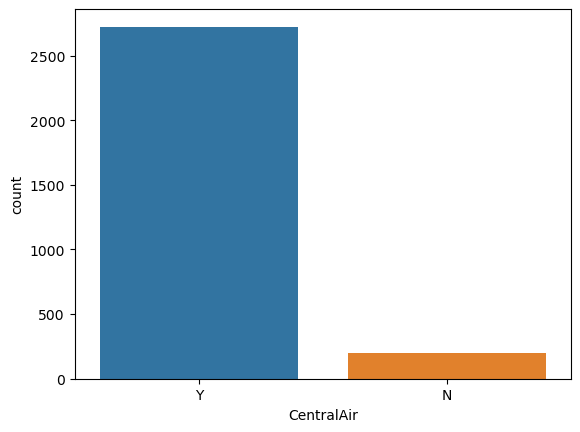

       Electrical      Ratio
SBrkr        2671  91.503940
FuseA         188   6.440562
FuseF          50   1.712915
FuseP           8   0.274066
Mix             1   0.034258
#############################################################################


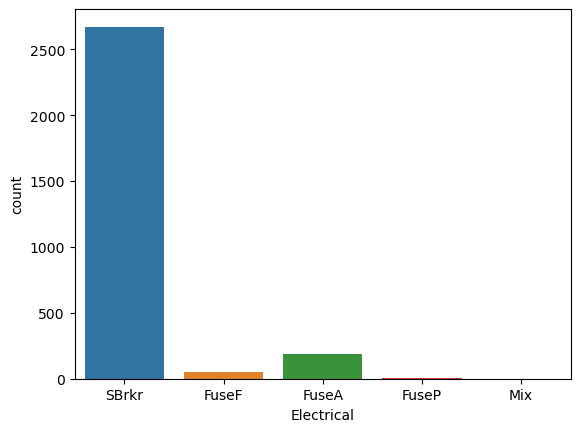

    KitchenQual      Ratio
TA         1492  51.113395
Gd         1151  39.431312
Ex          205   7.022953
Fa           70   2.398082
#############################################################################


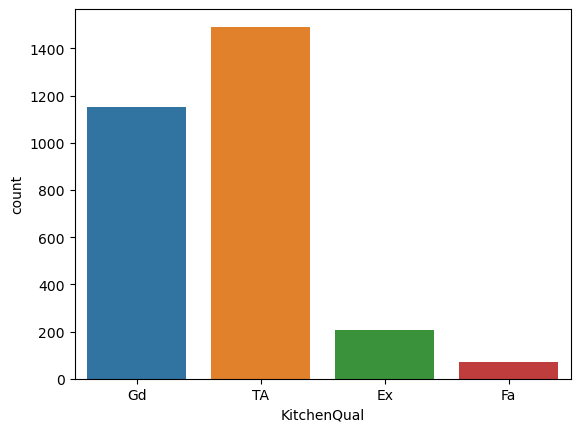

      Functional      Ratio
Typ         2717  93.079822
Min2          70   2.398082
Min1          65   2.226790
Mod           35   1.199041
Maj1          19   0.650908
Maj2           9   0.308325
Sev            2   0.068517
#############################################################################


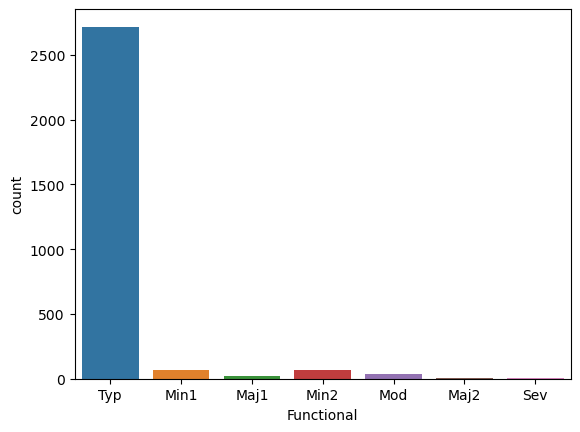

    FireplaceQu      Ratio
Gd          744  25.488181
TA          592  20.280918
Fa           74   2.535115
Po           46   1.575882
Ex           43   1.473107
#############################################################################


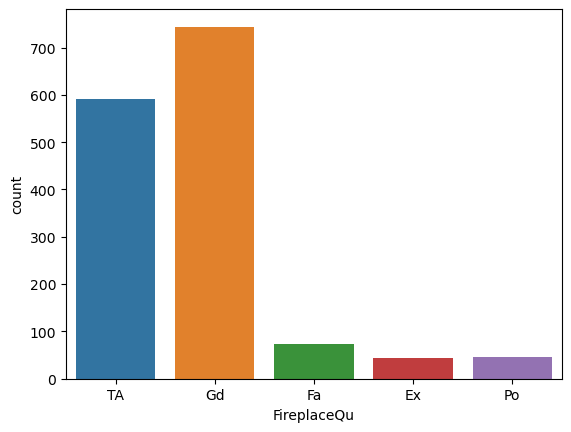

         GarageType      Ratio
Attchd         1723  59.027064
Detchd          779  26.687222
BuiltIn         186   6.372045
Basment          36   1.233299
2Types           23   0.787941
CarPort          15   0.513875
#############################################################################


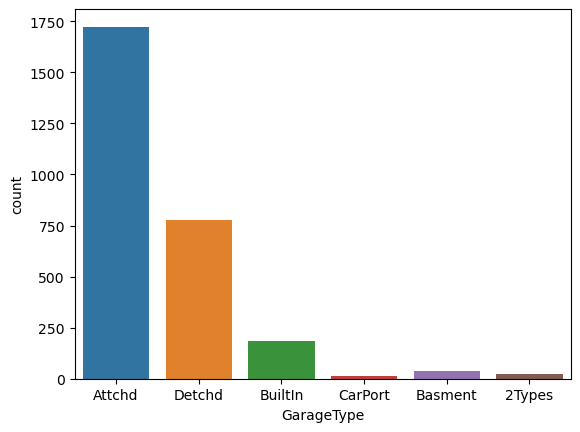

     GarageFinish      Ratio
Unf          1230  42.137718
RFn           811  27.783487
Fin           719  24.631723
#############################################################################


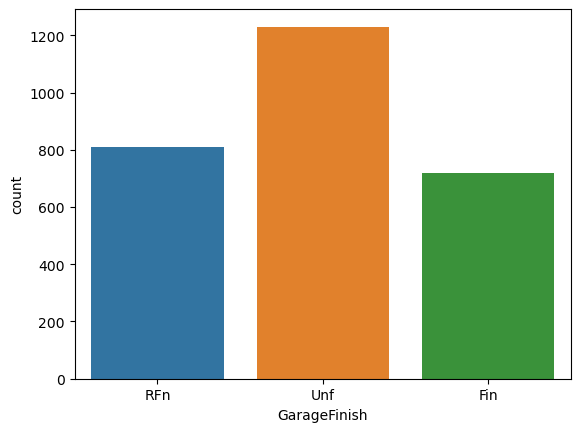

    GarageQual      Ratio
TA        2604  89.208633
Fa         124   4.248030
Gd          24   0.822199
Po           5   0.171292
Ex           3   0.102775
#############################################################################


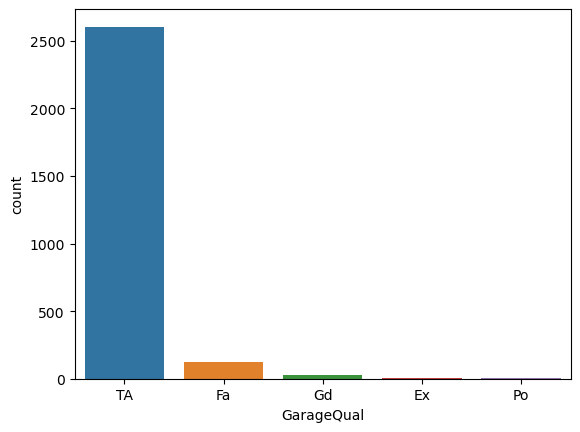

    GarageCond      Ratio
TA        2654  90.921548
Fa          74   2.535115
Gd          15   0.513875
Po          14   0.479616
Ex           3   0.102775
#############################################################################


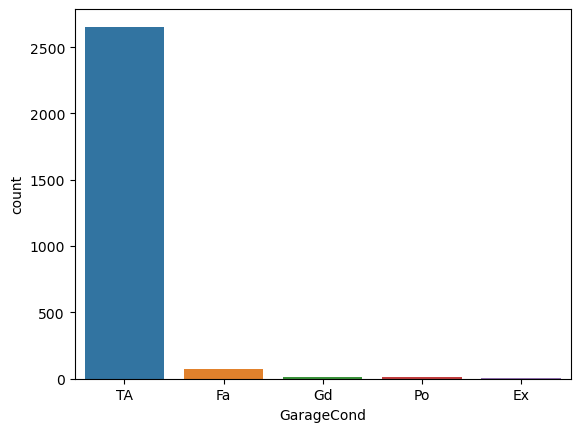

   PavedDrive      Ratio
Y        2641  90.476190
N         216   7.399794
P          62   2.124015
#############################################################################


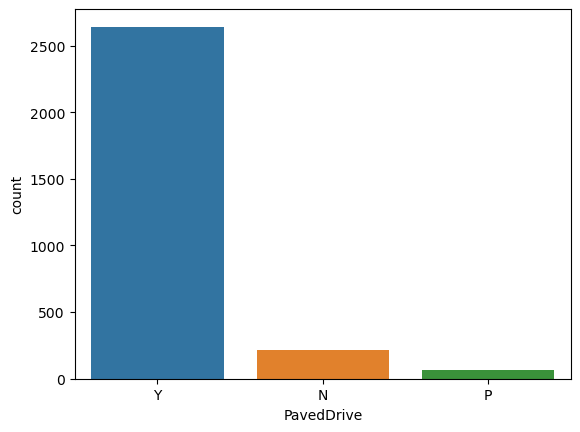

    PoolQC     Ratio
Ex       4  0.137033
Gd       4  0.137033
Fa       2  0.068517
#############################################################################


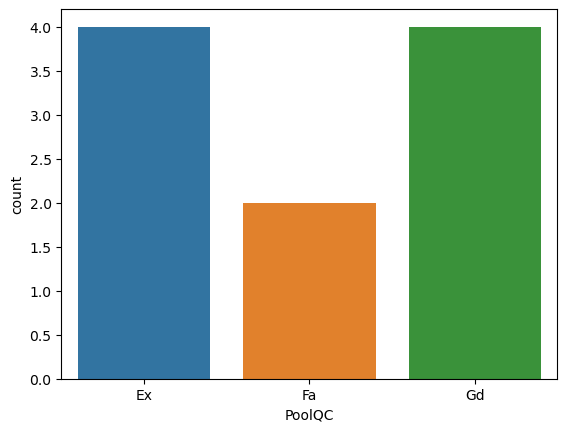

       Fence      Ratio
MnPrv    329  11.270983
GdPrv    118   4.042480
GdWo     112   3.836930
MnWw      12   0.411100
#############################################################################


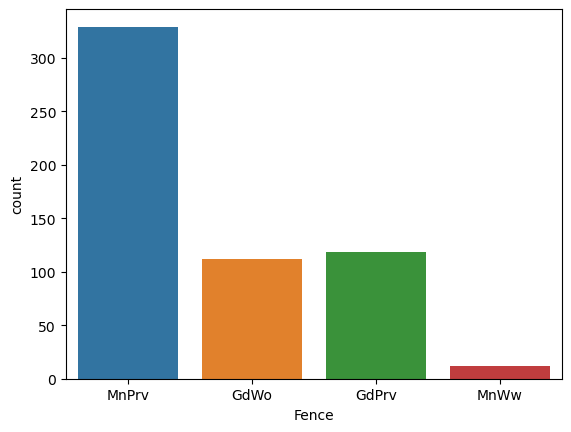

      MiscFeature     Ratio
Shed           95  3.254539
Gar2            5  0.171292
Othr            4  0.137033
TenC            1  0.034258
#############################################################################


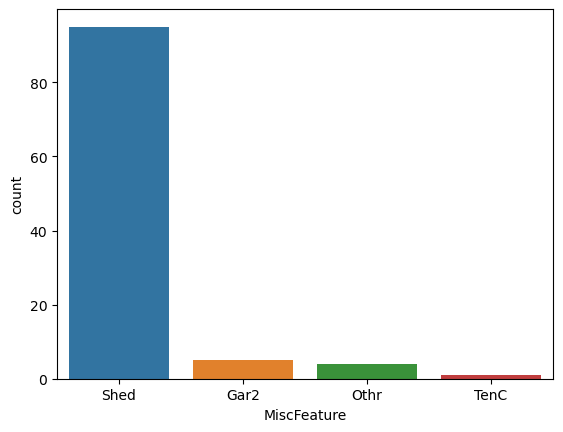

    MoSold      Ratio
6      503  17.231929
7      446  15.279205
5      394  13.497773
4      279   9.558068
8      233   7.982186
3      232   7.947927
10     173   5.926687
9      158   5.412813
11     142   4.864680
2      133   4.556355
1      122   4.179514
12     104   3.562864
#############################################################################


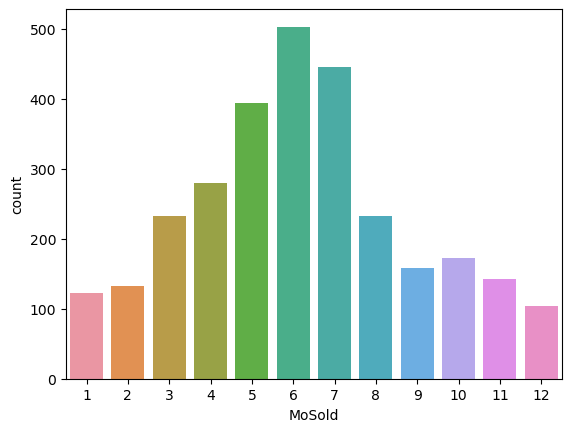

       SaleType      Ratio
WD         2525  86.502227
New         239   8.187736
COD          87   2.980473
ConLD        26   0.890716
CWD          12   0.411100
ConLI         9   0.308325
ConLw         8   0.274066
Oth           7   0.239808
Con           5   0.171292
#############################################################################


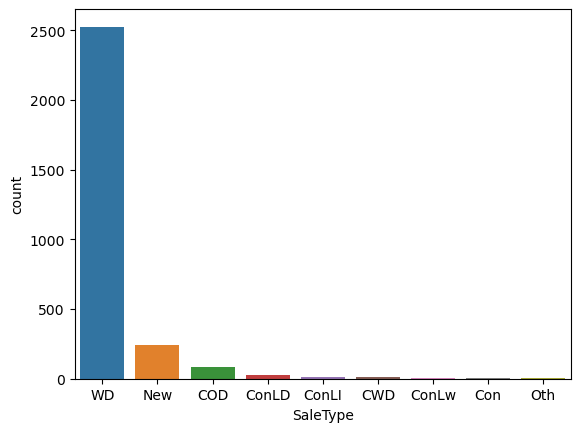

         SaleCondition      Ratio
Normal            2402  82.288455
Partial            245   8.393285
Abnorml            190   6.509078
Family              46   1.575882
Alloca              24   0.822199
AdjLand             12   0.411100
#############################################################################


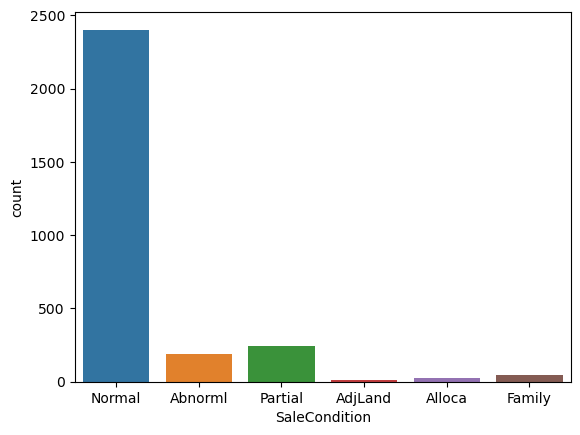

   OverallCond      Ratio
5         1645  56.354916
6          531  18.191161
7          390  13.360740
8          144   4.933196
4          101   3.460089
3           50   1.712915
9           41   1.404591
2           10   0.342583
1            7   0.239808
#############################################################################


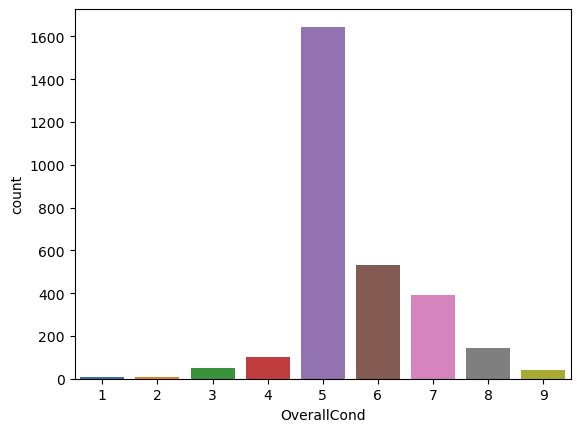

     BsmtFullBath      Ratio
0.0          1705  58.410415
1.0          1172  40.150737
2.0            38   1.301816
3.0             2   0.068517
#############################################################################


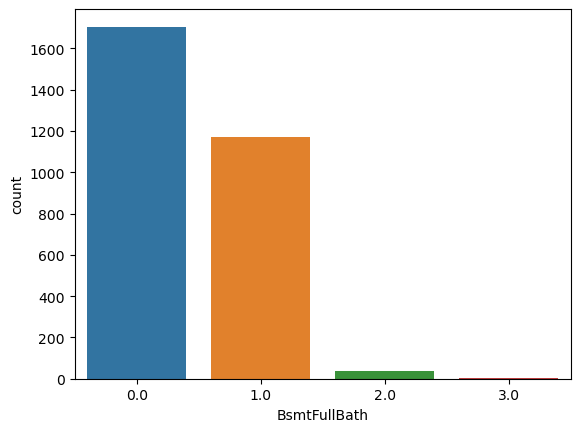

     BsmtHalfBath      Ratio
0.0          2742  93.936280
1.0           171   5.858171
2.0             4   0.137033
#############################################################################


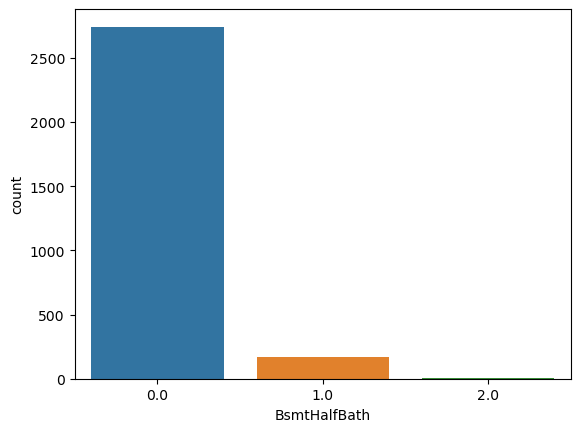

   FullBath      Ratio
2      1530  52.415211
1      1309  44.844125
3        64   2.192532
0        12   0.411100
4         4   0.137033
#############################################################################


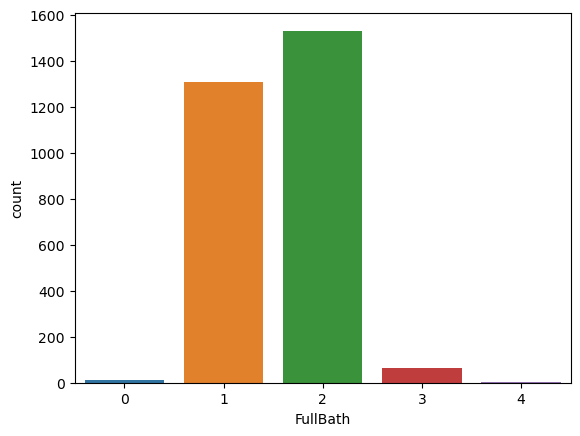

   HalfBath      Ratio
0      1834  62.829736
1      1060  36.313806
2        25   0.856458
#############################################################################


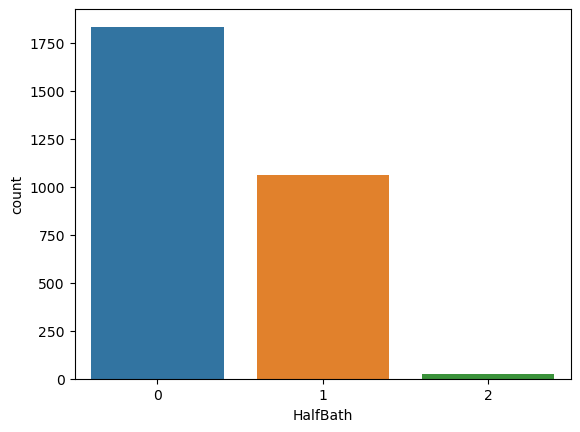

   BedroomAbvGr      Ratio
3          1596  54.676259
2           742  25.419664
4           400  13.703323
1           103   3.528606
5            48   1.644399
6            21   0.719424
0             8   0.274066
8             1   0.034258
#############################################################################


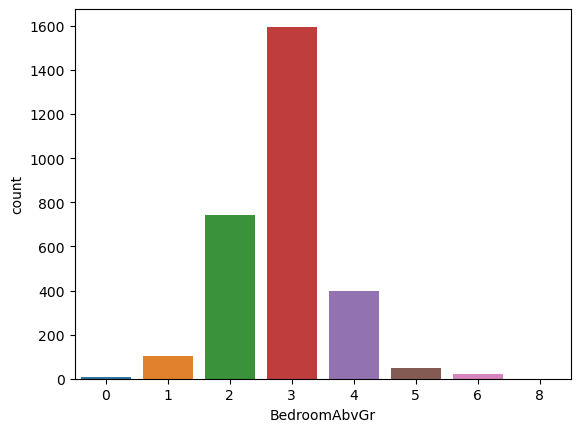

   KitchenAbvGr      Ratio
1          2785  95.409387
2           129   4.419322
0             3   0.102775
3             2   0.068517
#############################################################################


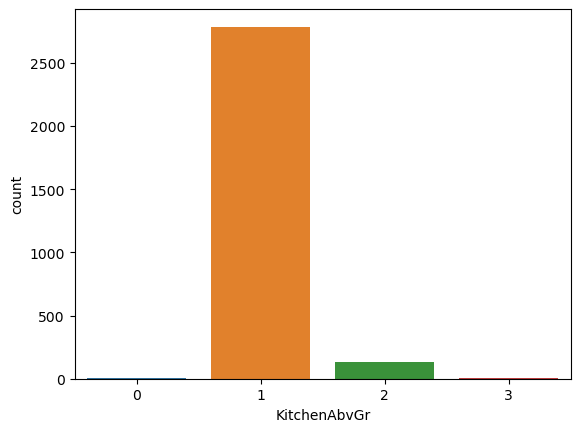

   Fireplaces      Ratio
0        1420  48.646797
1        1268  43.439534
2         219   7.502569
3          11   0.376841
4           1   0.034258
#############################################################################


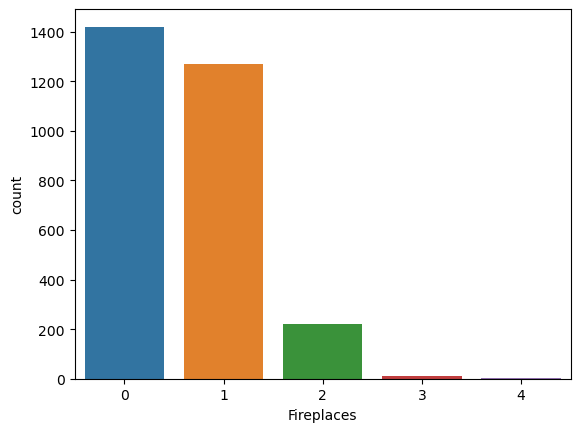

     GarageCars      Ratio
2.0        1594  54.607742
1.0         776  26.584447
3.0         374  12.812607
0.0         157   5.378554
4.0          16   0.548133
5.0           1   0.034258
#############################################################################


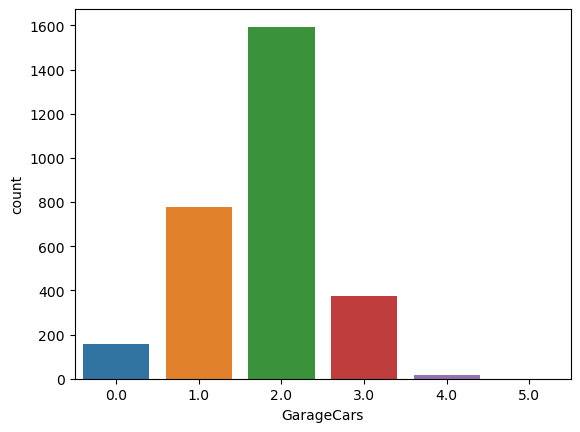

      YrSold      Ratio
2007     692  23.706749
2009     647  22.165125
2008     622  21.308667
2006     619  21.205892
2010     339  11.613566
#############################################################################


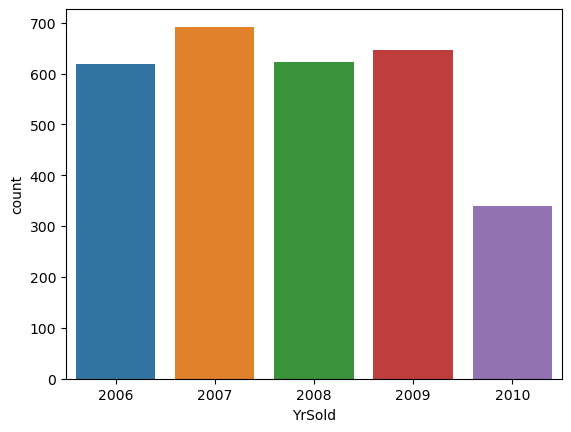

In [63]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

**Target Variables Analysis (SalePrice)**

In [64]:
def target_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"SalePrice Mean": dataframe.groupby(categorical_col)[target].mean()}))
    print("#########################################")

In [65]:
for col in cat_cols:
    target_cat(df, "SalePrice", col)

            SalePrice Mean
MSSubClass                
20           185224.811567
30            95829.724638
40           156125.000000
45           108591.666667
50           143302.972222
60           239948.501672
70           166772.416667
75           192437.500000
80           169736.551724
85           147810.000000
90           133541.076923
120          200779.080460
150                    NaN
160          138647.380952
180          102300.000000
190          129613.333333
#########################################
          SalePrice Mean
MSZoning                
C (all)     74528.000000
FV         214014.061538
RH         131558.375000
RL         191004.994787
RM         126316.830275
#########################################
        SalePrice Mean
Street                
Grvl     130190.500000
Pave     181130.538514
#########################################
       SalePrice Mean
Alley                
Grvl    122219.080000
Pave    168000.585366
#################################

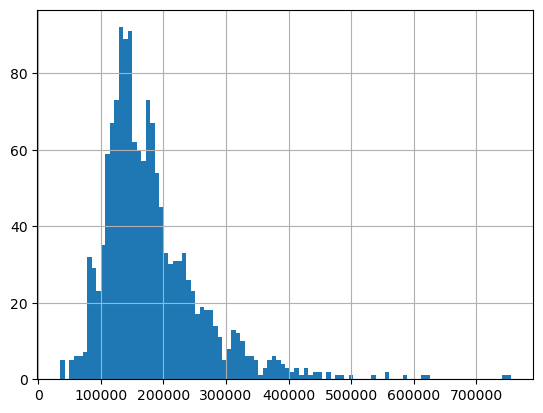

In [66]:
# Dependent variable analysis
df["SalePrice"].hist(bins=100)
plt.show(block=True)

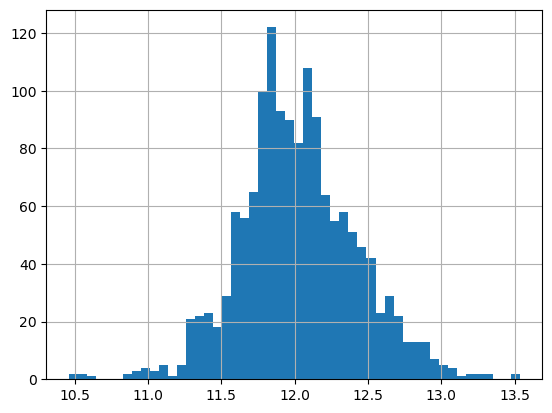

In [67]:
# Dependent variable logarithm analysis
np.log1p(df["SalePrice"]).hist(bins=50)
plt.show(block=True)

**Correlation Analysis**

In [68]:
corr = df[num_cols].corr()
corr

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,TotRmsAbvGrd,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
LotFrontage,1.000000,0.489896,0.122811,0.091557,0.221079,0.219408,0.047431,0.113714,0.354822,0.458247,0.026545,0.004894,0.382462,0.349513,0.076673,0.359786,0.122070,0.164896,0.011509,0.028289,0.075858,0.174119,0.044272,0.351799
LotArea,0.489896,1.000000,0.024128,0.021612,0.125596,0.194031,0.084059,0.021362,0.254138,0.332460,0.031515,0.000554,0.284519,0.213802,-0.008628,0.213251,0.158045,0.104797,0.020974,0.015995,0.054375,0.093708,0.069029,0.263843
YearBuilt,0.122811,0.024128,1.000000,0.612235,0.314051,0.279581,-0.027595,0.130473,0.408515,0.310814,0.017588,-0.144191,0.242666,0.114280,0.834812,0.480735,0.229426,0.198554,-0.374073,0.015958,-0.041046,0.002304,-0.010886,0.522897
YearRemodAdd,0.091557,0.021612,0.612235,1.000000,0.196875,0.152126,-0.062153,0.165175,0.298107,0.242245,0.158985,-0.060371,0.316972,0.198250,0.652365,0.376765,0.218513,0.242182,-0.220456,0.037433,-0.046878,-0.011407,-0.003124,0.507101
MasVnrArea,0.221079,0.125596,0.314051,0.196875,1.000000,0.303490,-0.015645,0.090163,0.397240,0.395834,0.121014,-0.057912,0.402994,0.278228,0.255112,0.374061,0.166200,0.144650,-0.111499,0.013612,0.065209,0.004512,0.044811,0.477493
BsmtFinSF1,0.219408,0.194031,0.279581,0.152126,0.303490,1.000000,-0.055045,-0.477404,0.536467,0.458092,-0.162301,-0.066028,0.211669,0.052141,0.194270,0.310449,0.223492,0.124163,-0.099712,0.050908,0.096823,0.084462,0.093295,0.386420
BsmtFinSF2,0.047431,0.084059,-0.027595,-0.062153,-0.015645,-0.055045,1.000000,-0.238241,0.089410,0.084330,-0.097744,-0.004923,-0.017872,-0.048423,-0.068549,0.003139,0.098399,-0.005876,0.032740,-0.023279,0.063302,0.044524,-0.005139,-0.011378
BsmtUnfSF,0.113714,0.021362,0.130473,0.165175,0.090163,-0.477404,-0.238241,1.000000,0.412285,0.296600,-0.000376,0.046913,0.233988,0.247505,0.171588,0.164409,-0.039302,0.119764,0.005006,-0.005810,-0.049158,-0.032273,-0.010492,0.214479
TotalBsmtSF,0.354822,0.254138,0.408515,0.298107,0.397240,0.536467,0.089410,0.412285,1.000000,0.801670,-0.205665,-0.023359,0.445276,0.282126,0.348408,0.486067,0.229600,0.245521,-0.085510,0.037892,0.075363,0.072216,0.084002,0.613581
1stFlrSF,0.458247,0.332460,0.310814,0.242245,0.395834,0.458092,0.084330,0.296600,0.801670,1.000000,-0.249823,-0.012704,0.562538,0.391782,0.260450,0.492011,0.227347,0.238502,-0.065796,0.044086,0.098381,0.121900,0.093062,0.605852


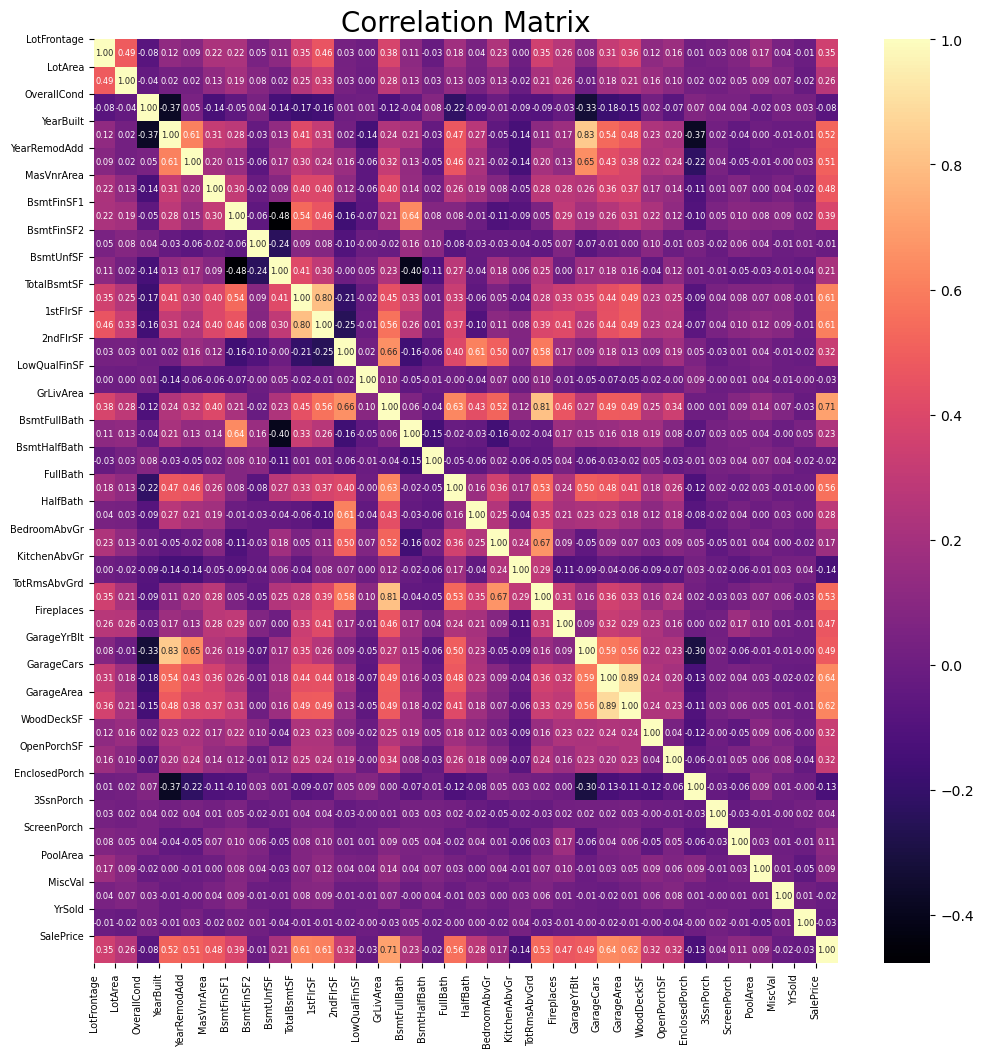

In [69]:
# Correlation Matrix
corr = df.corr()
f, ax = plt.subplots(figsize=[12, 12])
sns.heatmap(corr, annot=True, fmt=".2f", ax=ax, cmap="magma", annot_kws={"size": 6})
ax.set_title("Correlation Matrix", fontsize=20)
plt.xticks(range(len(corr.columns)), corr.columns, size=7);
plt.yticks(range(len(corr.columns)), corr.columns, size=7)
plt.show(block=True)

In [70]:
# Correlation Sort
df.corrwith(df["SalePrice"]).sort_values(ascending=False)

SalePrice        1.000000
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
dtype: float64

**Outlier Variables Analysis**

In [71]:
df.describe([0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
LotFrontage,2433.0,69.305795,23.344905,21.0,21.00,32.00,43.0,59.0,68.0,80.0,95.0,107.00,135.68,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,1680.00,3182.00,4922.4,7478.0,9453.0,11570.0,14300.6,17142.90,33038.64,215245.0
OverallCond,2919.0,5.564577,1.113131,1.0,3.00,4.00,5.0,5.0,5.0,6.0,7.0,8.00,9.00,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1900.00,1915.00,1924.0,1953.5,1973.0,2001.0,2006.0,2007.00,2008.00,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1950.00,1950.00,1950.0,1965.0,1993.0,2004.0,2006.2,2007.00,2009.00,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.00,0.00,0.0,0.0,0.0,164.0,325.5,466.50,771.05,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.00,0.00,0.0,0.0,368.5,733.0,1056.9,1274.00,1635.32,5644.0
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.00,0.00,0.0,0.0,0.0,0.0,125.6,435.00,874.66,1526.0
BsmtUnfSF,2918.0,560.772104,439.543659,0.0,0.00,0.00,56.0,220.0,467.0,805.5,1212.6,1474.90,1776.49,2336.0
TotalBsmtSF,2918.0,1051.777587,440.766258,0.0,0.00,455.25,600.0,793.0,989.5,1302.0,1614.0,1776.15,2198.30,6110.0


In [72]:
# Outlier Thresholds Determination
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [73]:
# Outlier Check
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(df, col))

LotFrontage True
LotArea True
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 True
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea False
TotRmsAbvGrd False
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch False
PoolArea True
MiscVal True
SalePrice False


In [74]:
# Replace outliers with thresholds
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df, col)

In [75]:
for col in num_cols:
    print(col, check_outlier(df, col))

LotFrontage False
LotArea False
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 False
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF False
1stFlrSF False
2ndFlrSF False
LowQualFinSF False
GrLivArea False
TotRmsAbvGrd False
GarageYrBlt False
GarageArea False
WoodDeckSF False
OpenPorchSF False
EnclosedPorch False
3SsnPorch False
ScreenPorch False
PoolArea False
MiscVal False
SalePrice False


**Missing Variables Analysis**

In [76]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

missing_values_table(df)

              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrType        24   0.82
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

In [79]:
# Let's set the null values to "No" since they are house properties (no_cols).
no_cols = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu",
           "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]

for col in no_cols:
    df[col].fillna("No", inplace=True)

In [80]:
missing_values_table(df)

              n_miss  ratio
SalePrice       1459  49.98
LotFrontage      486  16.65
GarageYrBlt      159   5.45
MasVnrType        24   0.82
MasVnrArea        23   0.79
MSZoning           4   0.14
BsmtFullBath       2   0.07
BsmtHalfBath       2   0.07
Functional         2   0.07
Utilities          2   0.07
Exterior2nd        1   0.03
BsmtFinSF1         1   0.03
BsmtFinSF2         1   0.03
BsmtUnfSF          1   0.03
Exterior1st        1   0.03
Electrical         1   0.03
KitchenQual        1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
SaleType           1   0.03
TotalBsmtSF        1   0.03


In [81]:
def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]
    temp_target = data[target]
    print("# BEFORE")
    print(data[variables_with_na].isnull().sum().sort_values(ascending=False), "\n\n")
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
    data[target] = temp_target
    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum().sort_values(ascending=False), "\n\n")
    return data

df = quick_missing_imp(df)

# BEFORE
SalePrice       1459
LotFrontage      486
GarageYrBlt      159
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
Exterior2nd        1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Exterior1st        1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
SaleType           1
TotalBsmtSF        1
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

SalePrice       1459
Electrical         0
SaleType           0
GarageArea         0
GarageCars         0
GarageYrBlt        0
Functional         0
KitchenQual        0
BsmtHalfBath       0
BsmtFullBath       0
MSZoning           0
LotFrontage        0
BsmtUnfSF          0
BsmtFinSF2         0
BsmtFinSF1         0
MasVnrArea         0
MasVnrType         0
Exterior2nd        0
Exterior1st        0
Utilities     

**Rare Analysis**

In [82]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "SalePrice", cat_cols)

MSSubClass : 16
     COUNT     RATIO    TARGET_MEAN
20    1079  0.369647  185224.811567
30     139  0.047619   95829.724638
40       6  0.002055  156125.000000
45      18  0.006166  108591.666667
50     287  0.098321  143302.972222
60     575  0.196985  239948.501672
70     128  0.043851  166772.416667
75      23  0.007879  192437.500000
80     118  0.040425  169736.551724
85      48  0.016444  147810.000000
90     109  0.037342  133541.076923
120    182  0.062350  200779.080460
150      1  0.000343            NaN
160    128  0.043851  138647.380952
180     17  0.005824  102300.000000
190     61  0.020898  129613.333333


MSZoning : 5
         COUNT     RATIO    TARGET_MEAN
C (all)     25  0.008565   74528.000000
FV         139  0.047619  214014.061538
RH          26  0.008907  131558.375000
RL        2269  0.777321  191004.994787
RM         460  0.157588  126316.830275


Street : 2
      COUNT     RATIO    TARGET_MEAN
Grvl     12  0.004111  130190.500000
Pave   2907  0.995889  181130.

**Rare Encoder**

In [83]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()
    # Fonksiyona girilen rare oranından daha düşük sayıda herhangi bir kategorik değişkenin sınıf oranlarını rare yap.
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
    return temp_df

df = rare_encoder(df, 0.01)

# 2-Feature Engineering #

In [84]:
# Total square meters
df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]

# Total number of rooms on upper floors (including bathroom)
df["Up_Total_Room"] = df["TotRmsAbvGrd"] + df["HalfBath"] + df["FullBath"]

# Total number of bathroom
df["Total_Bath"] = df["BsmtFullBath"] + df["BsmtHalfBath"] + df["FullBath"] + df["HalfBath"]

# Total number of room
df["Total_Room"] = df["Total_Bath"] + df["BedroomAbvGr"] + df["KitchenAbvGr"] + df["TotRmsAbvGrd"]

# Total porch area
df["Total_Porch_SF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]

# Division of building construction dates
df["YearBuilt"].max() # 2010
df["YearBuilt"].min() # 1872
label= ["1872_1900", "1901_1945", "1946_1975", "1976_1999", "2000_2010"]
df["NEW_YearBuilt"] = pd.cut(df["YearBuilt"], bins=5, labels=label)

# Division of building renovation dates
df["YearRemodAdd"].max() # 2010
df["YearRemodAdd"].min() # 1950
label1= ["1950_1969", "1970_1984", "1985_1999", "2000_2010"]
df["NEW_YearRemodAdd"] = pd.cut(df["YearRemodAdd"], bins=4, labels=label1)

# Age of House
df["NEW_HouseAge"] = df["YrSold"] - df["YearBuilt"]

In [85]:
drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]
df.drop(drop_list, axis=1, inplace=True)

**Label Encoding**

In [86]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and len(df[col].unique()) == 2]

for col in binary_cols:
    label_encoder(df, col)

Observations: 2919
Variables: 79
cat_cols: 48
num_cols: 31
cat_but_car: 0
num_but_cat: 14


**One-Hot Encoder**

In [87]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

# 3- Modeling #

In [88]:
# Train and Test sets separating
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

In [89]:
y = train_df["SalePrice"]
X = train_df.drop(["SalePrice"], axis=1)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [91]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

In [92]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 33506.3266 (LR) 
RMSE: 32466.589 (Ridge) 
RMSE: 33674.3114 (Lasso) 
RMSE: 33858.453 (ElasticNet) 
RMSE: 45294.9073 (KNN) 
RMSE: 41058.358 (CART) 
RMSE: 29897.8094 (RF) 
RMSE: 24903.3554 (GBM) 
RMSE: 28791.7876 (XGBoost) 
RMSE: 28314.8806 (LightGBM) 
RMSE: 25744.9576 (CatBoost) 


In [93]:
# Log Transformation
y = np.log1p(train_df['SalePrice'])
X = train_df.drop(["SalePrice"], axis=1)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [98]:
GBM_model = GradientBoostingRegressor().fit(X_train, y_train)
y_pred = GBM_model.predict(X_test)

In [99]:
y_pred
# Yapılan LOG dönüşümünün tersinin (inverse'nin) alınması
new_y = np.expm1(y_pred)
new_y
new_y_test = np.expm1(y_test)
new_y_test

np.sqrt(mean_squared_error(new_y_test, new_y))

21441.617632324618

In [116]:
GBM_model =  GradientBoostingRegressor()
rmse = np.mean(np.sqrt(-cross_val_score(GBM_model, X, y, cv=5, scoring="neg_mean_squared_error")))
rmse

0.1309394493457671

In [119]:
GBM_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [120]:
GBM_params = {"learning_rate": [0.01, 0.05, 0.1],
              "n_estimators": [500, 1000, 1500],
              "max_depth": [3, 6]
             }

In [121]:
GBM_gs_best = GridSearchCV(GBM_model,
                            GBM_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [122]:
GBM_gs_best.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}

**Final Model**

In [123]:
GBM_final = LGBMRegressor(**GBM_gs_best.best_params_).fit(X, y)

In [124]:
rmse = np.mean(np.sqrt(-cross_val_score(GBM_final, X, y, cv=5, scoring="neg_mean_squared_error")))
rmse

0.13047523184590307

# 4-Feature Importance #

In [125]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns}).head(30)
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

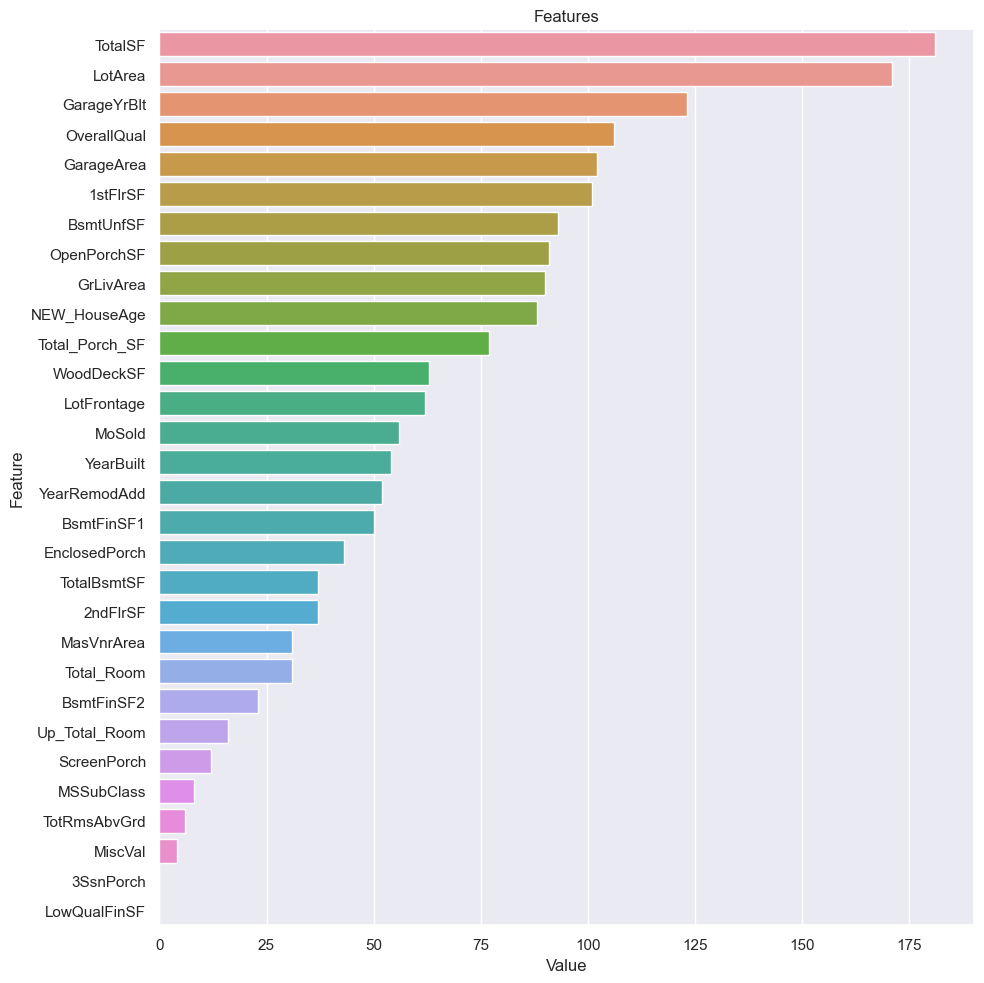

In [126]:
plot_importance(GBM_final, X)

In [127]:
predictions = np.exp(GBM_final.predict(test_df.drop(["SalePrice"], axis=1)))
output = pd.DataFrame({'Id': test_df.index, 'SalePrice': predictions})
output.to_csv('house_price_predict.csv', index=False)